In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import MDAnalysis as md

plt.rcParams.update({'font.size': 10})


output_directory = "figures"
if output_directory is not None:
    os.makedirs(output_directory, exist_ok=True)

/home/gmh4/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gmh4/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/gmh4/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gmh4/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
# inputs
gamma = 2.0 # BF/gamma=T+delT/T
kbt = 0.794882 # from PLUMED at 400.0K

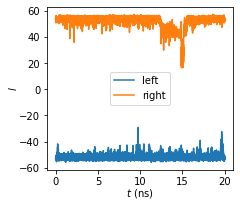

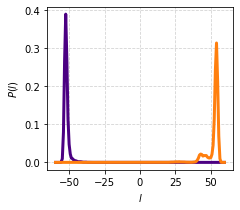

In [3]:
# load result from training data
ld_train_predict = np.loadtxt("/scratch/projects/hockygroup/ss12902/aib9_sGMM_torch/COLVAR")
time_in_ns = ld_train_predict[:len(ld_train_predict)//2,0]/1000

ld_left = ld_train_predict[:len(ld_train_predict)//2,1]
ld_right = ld_train_predict[len(ld_train_predict)//2:,1]
plt.figure(figsize=(3.33,3))



plt.plot(time_in_ns,ld_left,label='left')
plt.plot(time_in_ns,ld_right,label='right')
plt.ylabel("$l$",labelpad=0)
plt.xlabel("$t$ (ns)",labelpad=0)
plt.legend(loc='center')

if os.path.exists(output_directory):
    plt.savefig(os.path.join(output_directory,'aib9_ld_training.pdf'),bbox_inches='tight',dpi=300)

hist_left,bins = np.histogram(ld_left, bins=150, range=[-60,60], density=True)
grids = (bins[:-1]+bins[1:])/2.0

hist_right,bins = np.histogram(ld_right, bins=bins, density=True)
plt.figure(figsize=(3.33,3))

plt.ylabel("$P(l)$")
plt.xlabel("$l$")
plt.plot(grids, hist_left, color="indigo", lw=3.0)
plt.plot(grids, hist_right, color="tab:orange", lw=3.0)
plt.grid(axis="both", which="major", linestyle="--", color="lightgrey")

if output_directory is not None:
    plt.savefig(os.path.join(output_directory,"prob_ld_aib9_training.pdf"), format="pdf")

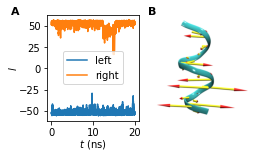

In [4]:
import string 
fig, axs = plt.subplots(1,2, figsize=(3.33,2))
axs[0].plot(time_in_ns,ld_left,label='left')
axs[0].plot(time_in_ns,ld_right,label='right')
axs[0].set_ylabel("$l$",labelpad=0)
axs[0].set_xlabel("$t$ (ns)",labelpad=0)
axs[0].legend(loc='center')
axs[0].set_xticks((0,10,20))

img = plt.imread(open("../aib9_porcupine_new_tight.tga",'rb'))
axs[1].imshow(img)
axs[1].axis('off')

axs[0].text(-0.4, 1.0, string.ascii_uppercase[0], transform=axs[0].transAxes, 
            size=11, weight='bold')

axs[0].text(1.1, 1.0, string.ascii_uppercase[1], transform=axs[0].transAxes, 
            size=11, weight='bold')

plt.tight_layout(pad=0)
if os.path.exists(output_directory):
    plt.savefig(os.path.join(output_directory,'aib9_training_porcupine.pdf'),bbox_inches='tight',dpi=250)

In [5]:
# read trajectory data
data_path = "/scratch/projects/hockygroup/ss12902/wt-metad_sims_aib9/height_0.005_bf_2.0/analysis"
backbone_selection_101 = "(name C and resid 1) or (name C CA N and not resid 1 9) or (name N and resid 9)"
print("selected atoms:", backbone_selection_101)

# load data
prmtopFileName =  data_path + "/left.gro"
trajFiles = [data_path+"/wt_metad_ld1_aib9_400K_height_0.005_bf_2.0_wrapped.xtc"]
print(trajFiles)
print(len(trajFiles))

coord = md.Universe(prmtopFileName,trajFiles)
sel_backbone_101 = coord.select_atoms(backbone_selection_101)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:",coord.trajectory.n_frames)
print("Number of atoms being analyzed:",sel_backbone_101.n_atoms)
print("Number of frames being analyzed:",coord.trajectory.n_frames)

trajData = np.empty((coord.trajectory.n_frames,sel_backbone_101.n_atoms,3),dtype=float)
count = 0

for ts in coord.trajectory:
    trajData[count,:,:] = sel_backbone_101.positions - sel_backbone_101.center_of_geometry()
    count += 1

selected atoms: (name C and resid 1) or (name C CA N and not resid 1 9) or (name N and resid 9)
['/scratch/projects/hockygroup/ss12902/wt-metad_sims_aib9/height_0.005_bf_2.0/analysis/wt_metad_ld1_aib9_400K_height_0.005_bf_2.0_wrapped.xtc']
1
Number of atoms in trajectory: 4749
Number of frames in trajectory: 150001
Number of atoms being analyzed: 23
Number of frames being analyzed: 150001


In [6]:
print(trajData.shape)

(150001, 23, 3)


In [7]:
# load ld1 data
time, ld1, meta_rbias =  np.loadtxt("/scratch/projects/hockygroup/ss12902/\
wt-metad_sims_aib9/height_0.005_bf_2.0/COLVAR", usecols=(0,1,3), unpack=True)

time *= 1e-3  # in ns

In [8]:
# load zeta value
zeta = np.load("/scratch/projects/hockygroup/ss12902/wt-metad_sims_aib9/height_0.005_bf_2.0/analysis/zeta.npy", allow_pickle=True)
print(zeta.shape)

(150001,)


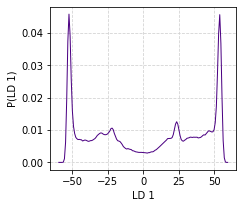

In [9]:
# plot P(LD 1) vs. time
hist,bins = np.histogram(ld1, bins=150, range=[-60,60], density=True)
grids = (bins[:-1]+bins[1:])/2.0

plt.figure(figsize=(3.33,3))
plt.ylabel("P(LD 1)")
plt.xlabel("LD 1")
plt.plot(grids, hist, color="indigo", lw=1.0)
plt.grid(axis="both", which="major", linestyle="--", color="lightgrey")

if output_directory is not None:
    plt.savefig(os.path.join(output_directory,"prob_ld1_aib9.pdf"), format="pdf")

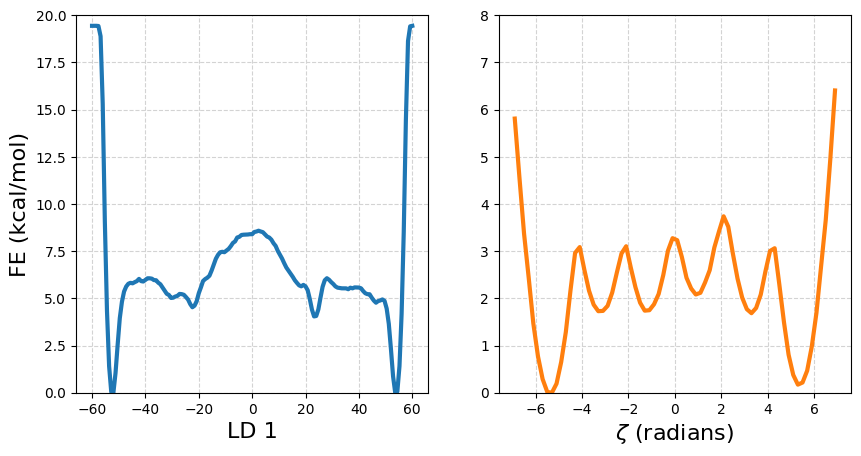

In [10]:
fig, axs = plt.subplots(1,2, figsize=(10,5), dpi=100)

# load fe data
grids, fe = np.loadtxt("/scratch/projects/hockygroup/ss12902/\
wt-metad_sims_aib9/height_0.005_bf_2.0/analysis/fe_vs_ld1.txt", usecols=(0,1), unpack=True)

fe *= (gamma/(gamma-1))

# plot fe vs. ld1
axs[0].set_xlabel("LD 1", fontsize=16)
axs[0].set_ylabel("FE (kcal/mol)", fontsize=16)
axs[0].grid(axis="both", which="major", linestyle="--", color="lightgrey")
axs[0].set_ylim(0.0,20.0)
axs[0].plot(grids, fe, color="tab:blue", lw=3.0)


# plot fe vs. zeta
nbins=70

hist, bins = np.histogram(zeta, bins=nbins, range=[-7,7], density=True, weights=np.exp(meta_rbias[::10]/kbt))
grids = (bins[1:]+ bins[:-1])/2.0
fe = -kbt*np.log(hist)
fe -= fe.min()
axs[1].set_ylim(0.0,8.0)
axs[1].set_xlabel("$\zeta$ (radians)", fontsize=16)
#axs[1].set_ylabel("FE (kcal/mol)", fontsize=16)
axs[1].grid(axis="both", which="major", linestyle="--", color="lightgrey")
axs[1].plot(grids, fe, lw=3.0, color="tab:orange")

if output_directory is not None:
    plt.savefig(os.path.join(output_directory,"fe_vs_ld1_zeta_from_metad_aib9.pdf"), format="pdf")

### Load 1.5 $\mu$s long MD simulation data (ld1 and zeta)

<ipython-input-11-fc107ab1aa3b>:9: RuntimeWarning: divide by zero encountered in log
  fe_md = -kbt*np.log(hist)


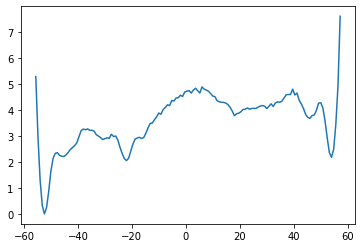

In [11]:
ld1_md, zeta_md = np.loadtxt("/scratch/projects/hockygroup/ss12902/md_sims_aib9/left/long_cmd/COLVAR", usecols=(1,2), unpack=True)

ld1_range = [-60,60]
nbins=150

hist, bins = np.histogram(ld1_md, range=ld1_range, bins=nbins, density=True)
grids_md = (bins[1:]+bins[:-1])/2.0

fe_md = -kbt*np.log(hist)
fe_md -= fe_md.min()

plt.plot(grids_md, fe_md)

## plot LD1 vs. time (MD and wt-metad)

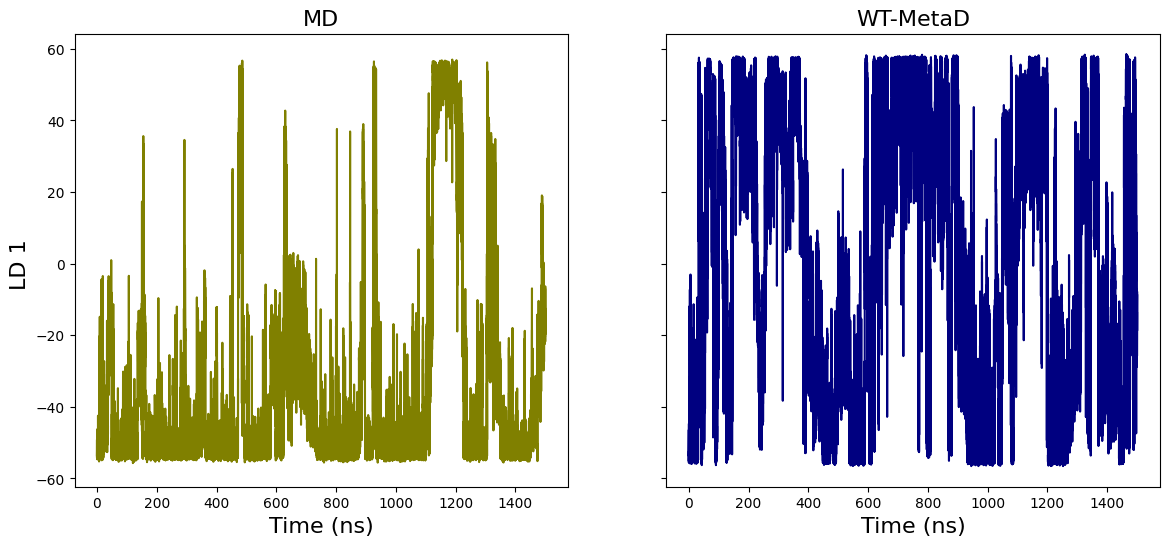

In [12]:
fig, axs = plt.subplots(1,2, sharey=True, sharex=True, figsize=(14,6), dpi=100)

# MD
axs[0].set_title("MD", fontsize=16)
axs[0].set_ylabel("LD 1 ", fontsize=16)
axs[0].set_xlabel("Time (ns)", fontsize=16)
axs[0].plot(np.arange(ld1_md.shape[0])*1e-2, ld1_md, color="olive")

# WT-MetaD
axs[1].set_title("WT-MetaD", fontsize=16)
axs[1].set_xlabel("Time (ns)", fontsize=16)
axs[1].plot(time, ld1, color="navy")

if output_directory is not None:
    plt.savefig(os.path.join(output_directory,"ld1_vs_time_compare_aib9.pdf"), format="pdf")

## plot zeta vs. time (MD and wt-metad)

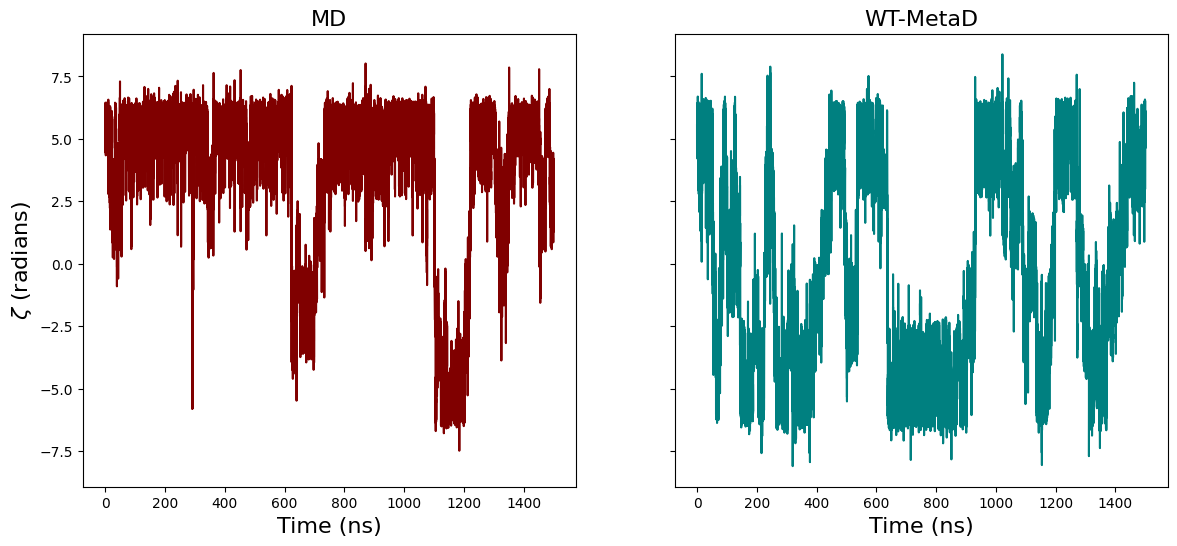

In [13]:
fig, axs = plt.subplots(1,2, sharey=True, sharex=True, figsize=(14,6), dpi=100)

# MD
axs[0].set_title("MD", fontsize=16)
axs[0].set_ylabel("$\\zeta$ (radians)", fontsize=16)
axs[0].set_xlabel("Time (ns)", fontsize=16)
axs[0].plot(np.arange(zeta_md.shape[0])*1e-2, zeta_md, color="maroon")

# WT-MetaD
axs[1].set_title("WT-MetaD", fontsize=16)
axs[1].set_xlabel("Time (ns)", fontsize=16)
axs[1].plot(np.arange(zeta.shape[0])*1e-2, zeta, color="teal")

if output_directory is not None:
    plt.savefig(os.path.join(output_directory,"zeta_vs_time_compare_aib9.pdf"), format="pdf")

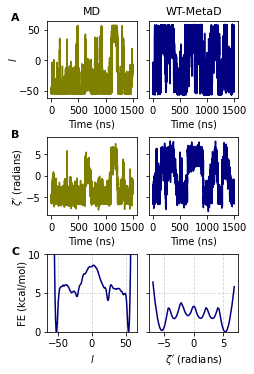

In [14]:
# combine figures
import string 
fig, axs = plt.subplots(3,2, figsize=(3.33,5), sharey='row')
plt.subplots_adjust(wspace=0.1)

# MD
axs[0,0].set_title("MD", fontsize=11)
axs[0,0].set_ylabel("$l$",labelpad=0)
axs[0,0].plot(np.arange(ld1_md.shape[0])*1e-2, ld1_md, color="olive")
axs[0,0].set_xticks((0,500,1000,1500))
axs[0,0].set_xlabel("Time (ns)")


# WT-MetaD
axs[0,1].set_title("WT-MetaD", fontsize=11)
axs[0,1].plot(time, ld1, color="navy")
axs[0,1].set_xticks((0,500,1000,1500))
axs[0,1].set_xlabel("Time (ns)")



# MD
axs[1,0].set_ylabel("$\\zeta'$ (radians)",labelpad=0)
axs[1,0].plot(np.arange(zeta_md.shape[0])*1e-2, -zeta_md, color="olive")
axs[1,0].set_xlabel("Time (ns)")
axs[1,0].set_xticks((0,500,1000,1500))


# WT-MetaD
axs[1,1].plot(np.arange(zeta.shape[0])*1e-2, -zeta, color="navy")
axs[1,1].set_xlabel("Time (ns)")
axs[1,1].set_xticks((0,500,1000,1500))


# load fe data
grids, fe = np.loadtxt("/scratch/projects/hockygroup/ss12902/\
wt-metad_sims_aib9/height_0.005_bf_2.0/analysis/fe_vs_ld1.txt", usecols=(0,1), unpack=True)

fe *= (gamma/(gamma-1))

# plot fe vs. ld1
axs[2,0].set_xlabel("$l$")
axs[2,0].set_ylabel("FE (kcal/mol)",labelpad=0)
axs[2,0].grid(axis="both", which="major", linestyle="--", color="lightgrey")
#axs[2,0].set_ylim(0.0,20.0)
axs[2,0].plot(grids, fe, color="navy")


# plot fe vs. zeta
nbins=70

hist, bins = np.histogram(zeta, bins=nbins, range=[-7,7], density=True, weights=np.exp(meta_rbias[::10]/kbt))
grids = (bins[1:]+ bins[:-1])/2.0
fe = -kbt*np.log(hist)
fe -= fe.min()
axs[2,1].set_ylim(0.0,10.0)
axs[2,1].set_xlabel("$\zeta'$ (radians)")
axs[2,1].grid(axis="both", which="major", linestyle="--", color="lightgrey")
axs[2,1].plot(-grids, fe,  color="navy")

axs=axs.flat
for n, ax in enumerate(axs):
    if not n%2==0:continue
    ax.text(-0.4, 1.0, string.ascii_uppercase[n//2], transform=ax.transAxes, 
            size=11, weight='bold')
    
plt.tight_layout(pad=0)
if os.path.exists(output_directory):
    plt.savefig(os.path.join(output_directory,'aib9_results_summary.pdf'),bbox_inches='tight')

## make the vmd script for porcupine plot in AIB9

In [15]:
forFile = "/scratch/projects/hockygroup/ss12902/wt-metad_sims_aib9/height_0.005_bf_2.0/ld1_scalings.txt"
vmdFile = "vmd_porcupine.tcl"

#new_univ = md.Universe("/scratch/projects/hockygroup/ss12902/wt-metad_sims_aib9/height_0.005_bf_2.0/analysis/left.gro")
new_univ = md.Universe("/scratch/projects/hockygroup/ss12902/pLDA_paper_data_final/aib9/left_centered.gro")

atoms = new_univ.select_atoms(backbone_selection_101)
print(atoms.indices.shape)
positions = atoms.positions
print(positions.shape)
forces_data = np.loadtxt(forFile) 

vmdOut = open(vmdFile,"w")
for atom in range(positions.shape[0]):
    forces = forces_data[atom*3:atom*3+3:]
    #mid = positions[atom,:] + 0.5*forces
    mid = positions[atom,:] + 0.8*forces
    end = positions[atom,:] + forces
    vmdOut.write("draw color yellow\n")
    vmdOut.write("draw cylinder {%10.3f %10.3f %10.3f} {%10.3f %10.3f %10.3f} radius 0.15 filled yes\n" % (positions[atom,0],positions[atom,1],positions[atom,2],mid[0],mid[1],mid[2]))
    vmdOut.write("draw color red\n")
    vmdOut.write("draw cone {%10.3f %10.3f %10.3f} {%10.3f %10.3f %10.3f} radius 0.25\n" % (mid[0],mid[1],mid[2],end[0],end[1],end[2]))

vmdOut.close()

(23,)
(23, 3)
